In [1]:
#all imports
import networkx as nx
import matplotlib.pyplot as plt
import random 
from string import ascii_lowercase
import numpy as np
import time
import random, operator, pandas as pd
from numpy.random import choice
from IPython.display import clear_output
import math
import datetime
from networkx.algorithms import tournament
from bokeh.models import CustomJS, Slider, Button
from bokeh.layouts import row, column
from bokeh.plotting import show
from bokeh.io import output_notebook
from datetime import timedelta, date
import warnings
warnings.simplefilter('ignore')

In [2]:
output_notebook()

#city class struct
class City:
    def __init__(self, key, name):
        self.key = key
        self.name = name
     
    def distance(self, city):
        dist = nx.astar_path_length(G, self.key, city.key, None, "distance")
        
        # calculate trafic coef
        nodesCrossed = len(nx.astar_path(G, self.key, city.key, None, None))-1
        trafic = nx.astar_path_length(G, self.key, city.key, None, "trafic")
        trafic_coef = (trafic / nodesCrossed) / MAX_TRAFIC
        return dist * trafic_coef
    
    def __repr__(self):
        return "(City :" + self.name + "; with key: " + str(self.key) + ")"

class Road:
    def __init__(self, key, id_city_1, id_city_2):
        self.key = key
        self.id_city_1 = id_city_1
        self.id_city_2 = id_city_2
        self.trafic = random.randint(1, MAX_TRAFIC)
        #self.traficList = generateTraficList()
            
    def generateTraficList(self):
        tL = []
        start_date = startDate
        end_date = endDate
        delta = timedelta(minutes=1)
        while start_date <= end_date:
            print (start_date.strftime("%Y-%m-%d"))
            start_date += delta
            nbrCars = random.randint(0,100)
            if (timedelta(hours=7) <= timedelta(hours=start_date.hour) < timedelta(hours=9)) or (timedelta(hours=17) <= timedelta(hours=start_date.hour) < timedelta(hours=19)):
                nbrCars = nbrCars * 5
            trafic = Trafic(self.key,start_date,nbrCars)
            tL.append(trafic)
        return tL
        

    def __repr__(self):
        return "(Road :" + str(self.key) + "; City 1 => " + str(self.id_city_1) + "; City 2 => " + str(self.id_city_2) + ")"

class Trafic:
    def init(self, id_road, date, nbr_vehicules):
        self.id_road = id_road
        self.date = date
        self.nbr_vehicules = nbr_vehicules

    def __repr__(self):
        return "(Trafic : Road:" + self.id_road + "; Date:" + str(self.date) + "; Nombre de véhicules: " + str(self.nbr_vehicules) + ")"
        
#class to calcul the route distance then the fitness value
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness


def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

def initialPopulation(popSize, cityList):
    population = []
    
    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

def selectOne(popRanked):
    max = sum([indiv[1] for indiv in popRanked])
    selection_probs = [indiv[1]/max for indiv in popRanked]
    return popRanked[choice(len(popRanked), p=selection_probs)][0]

def selection(popRanked, eliteSize):
    selectionResults = []
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    
    for i in range(0, len(popRanked) - eliteSize):
        indiv = selectOne(popRanked);
        selectionResults.append(indiv)
        
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

def crossover(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

def crossoverPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = crossover(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    for i in range(0, len(population)):
        mutatedIndividual = mutate(population[i], mutationRate)
        mutatedPop.append(mutatedIndividual)
    return mutatedPop

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = crossoverPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    for i in range(0, generations):
        print("Génération: n°" + str(i))
        pop = nextGeneration(pop, eliteSize, mutationRate)
        bestRouteIndex = rankRoutes(pop)[0][0]
        bestRoute = pop[bestRouteIndex]
        #clear_output(True)
        #displayGraph(bestRoute)

    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    data = nx.readwrite.json_graph.node_link_data(G)
    print(data)
    #TODO STORE GRAPH IN MONGO DB
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    displayGraph(bestRoute)
    return bestRoute

#to reload cities name file txt
def reloadCitiesName():
    citiesName = []
    try:
        with open('FrenchCitieslist.txt', 'rU') as infile:
            wordSet = set(line.strip() for line in infile)
    except IOError:
           print('error opening file')

    for aWord in wordSet:
        citiesName.append(aWord)
    return citiesName

def displayGraph(route):
    edges = [(route[i].key, route[i+1].key) for i in range(len(route)) if i < len(route)-1]
    edges.append((route[len(route)-1].key,route[0].key))
    plt.figure(figsize=(15, 15))
    plt.title("Carte routière")
    ax = plt.subplot(1,1,1)
    edge_labels = dict([((u,v),"Dist: " + str(d['distance']) + " ; Trafic: " + str(d['trafic'])) for u,v,d in G.edges(data=True)])    
    nx.draw_networkx(G,pos, node_size=200,node_color="skyblue", alpha=0.5,node_shape="s", linewidths=30, ax =ax)
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="red", ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_labels(G, pos, labels,font_size=10,font_weight='bold')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.axis("off")
    plt.show()
    
def main():
    citiesName = reloadCitiesName()
    
    # add distance and traffic on each edge randomly
    
    for u,v in G.edges():
        road = Road(len(roadList),u,v)
        G.edges[u,v]["distance"] = random.randint(1, 10)
        G.edges[u,v]["trafic"] = road.trafic
        roadList.append(road)
        
    for n in G.nodes():
        selection = random.randint(0, len(citiesName)-1)
        name = citiesName.pop(selection)
        labels[n] = name
        cityList.append(City(n, name))
    
    geneticAlgorithm(population=cityList,popSize=POPSIZE,eliteSize=ELITESIZE,mutationRate=MUTATIONRATE,generations=GENERATIONS)
    




Loading BokehJS ...

Initial distance: 20.425
Génération: n°0
Génération: n°1
Génération: n°2
Génération: n°3
Génération: n°4
Génération: n°5
Génération: n°6
Génération: n°7
Génération: n°8
Génération: n°9
Génération: n°10
Génération: n°11
Génération: n°12
Génération: n°13
Génération: n°14
Génération: n°15
Génération: n°16
Génération: n°17
Génération: n°18
Génération: n°19
Génération: n°20
Génération: n°21
Génération: n°22
Génération: n°23
Génération: n°24
Génération: n°25
Génération: n°26
Génération: n°27
Génération: n°28
Génération: n°29
Génération: n°30
Génération: n°31
Génération: n°32
Génération: n°33
Génération: n°34
Génération: n°35
Génération: n°36
Génération: n°37
Génération: n°38
Génération: n°39
Génération: n°40
Génération: n°41
Génération: n°42
Génération: n°43
Génération: n°44
Génération: n°45
Génération: n°46
Génération: n°47
Génération: n°48
Génération: n°49
Final distance: 14.049999999999999
{'directed': False, 'multigraph': False, 'graph': {}, 'nodes': [{'id': 0}, {'id': 1}, {'id': 2}, {'i

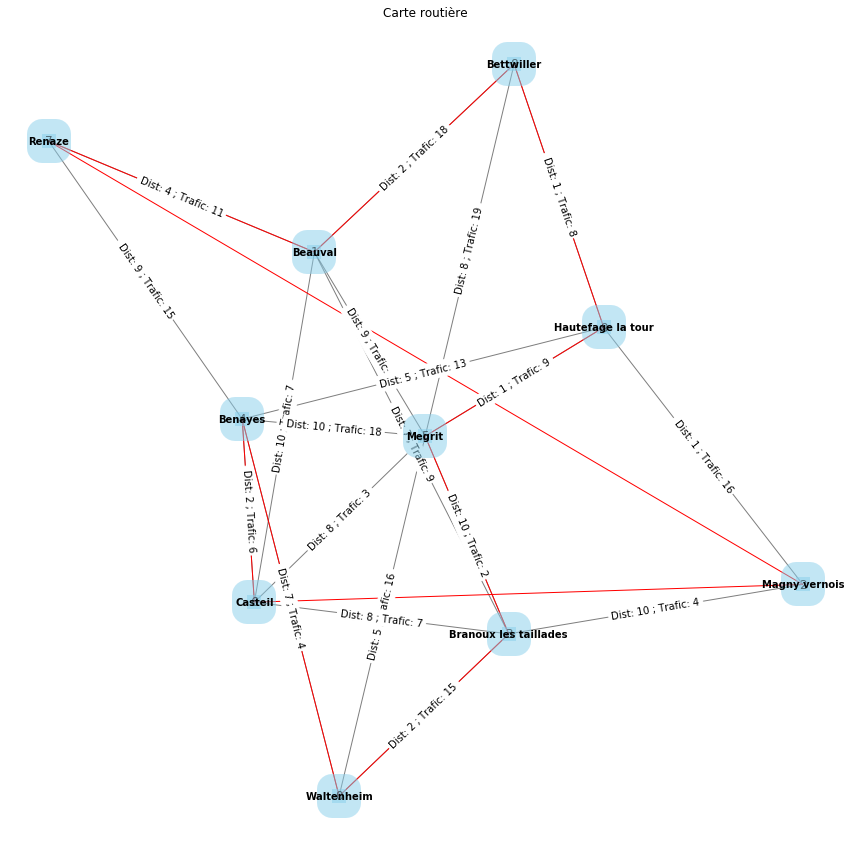

Time of Execution :
Wall time: 8.93 s


In [3]:
%%time 

NBR_CITIES = 10
MAX_TRAFIC = 20
NBR_NEAREST_NEIGHBORS = 4
REWIRING_PROBABILITY = 1
POPSIZE = 50
ELITESIZE = 10
MUTATIONRATE = 0.01
GENERATIONS = 50

START_DATE = datetime.datetime(2020, 1, 1, 0, 0)
END_DATE = datetime.datetime(2020,1, 5, 19, 0)

roadList = []
cityList = []
labels = {}
G = nx.connected_watts_strogatz_graph(NBR_CITIES,NBR_NEAREST_NEIGHBORS,REWIRING_PROBABILITY)
#G_data = nx.readwrite.json_graph.node_link_data(H)
#G = nx.readwrite.json_graph.node_link_graph(G_data)

pos = nx.spring_layout(G)

main()

print("Time of Execution :") #don't delete, using magic cell statement

### 